In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys 
import os
import skimage.io
import caffe
caffe.set_mode_gpu()

import visualisation
import excitation_backprop
import debug
import beoid

%load_ext autoreload
%autoreload 2

In [2]:
import beoid_spatial_config
import beoid_temporal_config

spatial_net_config = beoid_spatial_config
temporal_net_config = beoid_temporal_config
spatial_net_name = "vgg16-spatial-beoid"
temporal_net_name = "vgg16-temporal-beoid"

spatial_net = caffe.Net(spatial_net_config.net_prototxt_path,
                spatial_net_config.net_caffemodel_path,
                caffe.TEST)
temporal_net = caffe.Net(temporal_net_config.net_prototxt_path,
                temporal_net_config.net_caffemodel_path,
                caffe.TEST)


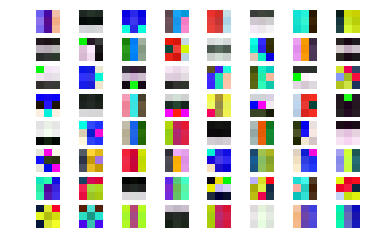

In [3]:
spatial_filters = visualisation.show_filters(spatial_net, 'conv1_1')
spatial_filters.savefig(spatial_net_name + '-filters.pdf')
spatial_filters

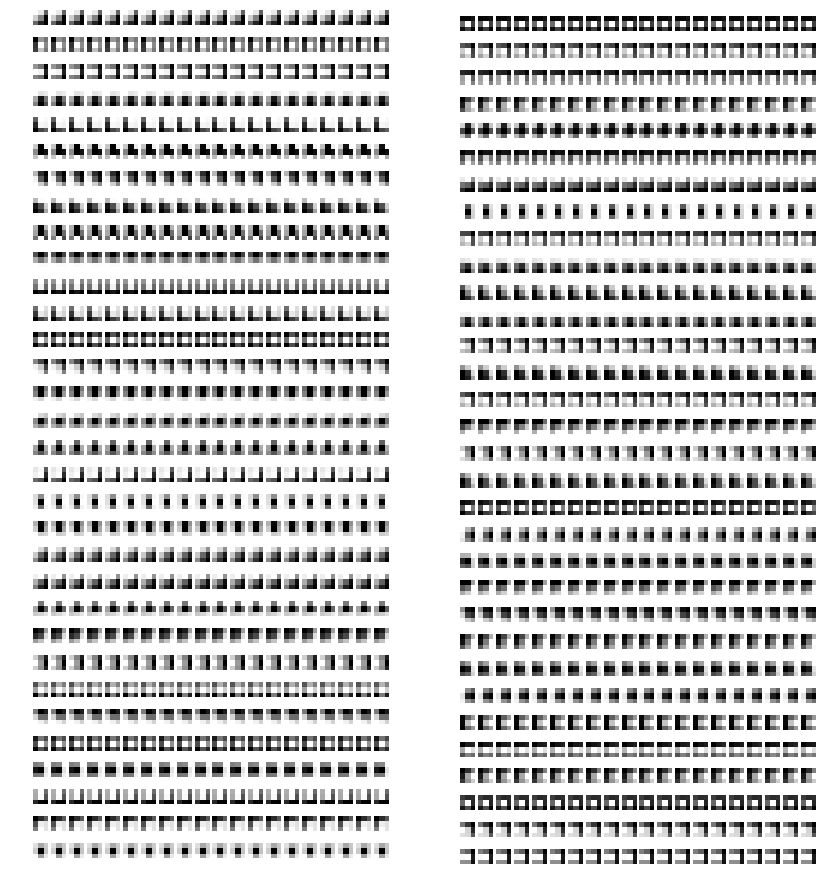

In [4]:
temporal_filter_vis = visualisation.show_grayscale_filters(temporal_net, 'conv1_1')

fig, axes = plt.subplots(1, 2, figsize=(14, 30))
axes[0].imshow(np.split(temporal_filter_vis, 2)[0], cmap='gray', interpolation='nearest')
axes[1].imshow(np.split(temporal_filter_vis, 2)[1], cmap='gray', interpolation='nearest')
for ax in axes:
    ax.axis('off')
fig.savefig(temporal_net_name + '-filters.pdf')
fig